In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pathlib

from MulticoreTSNE import MulticoreTSNE as TSNE
from functools import partial
import datashader as ds
import datashader.transfer_functions as dtf
from datashader.mpl_ext import dsshow

import torch
from torch.utils.data import DataLoader
from torch.nn import ReLU, MSELoss

from py.datasets.mnist import CachedMNIST
from py.datasets.bmnist import CachedBMNIST
from py.dec.torch.sdae import StackedDenoisingAutoEncoder
from py.dec.torch.dec import DEC
from py.dec.torch.utils import get_linears, cluster_accuracy


Setting global variables

In [2]:
PATH_TO_MODELS = pathlib.Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/results')
PATH_TO_DATA = '/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/data/mnist/'
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

Getting dataset

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
binary = False
if binary:
    ds_val = CachedBMNIST(
        train=False, device=device,
        path=PATH_TO_DATA,
    )  # evaluation dataset
    filename = 'bmnist_cl_best'
else:
    ds_val = CachedMNIST(
        train=False, device=device,
        path=PATH_TO_DATA,
    )  # evaluation dataset
    filename = 'mnist_cl_best'
validation_loader = DataLoader(
    ds_val,
    batch_size=256,
    shuffle=False,
)

Initializing model.

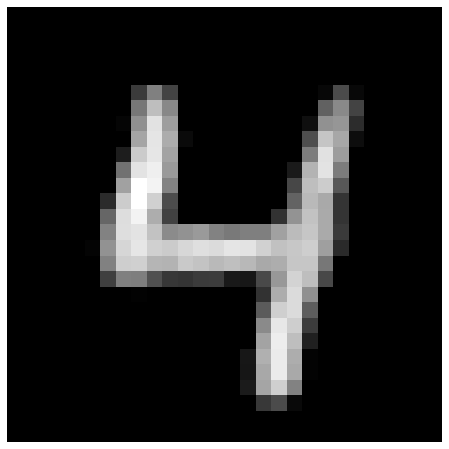

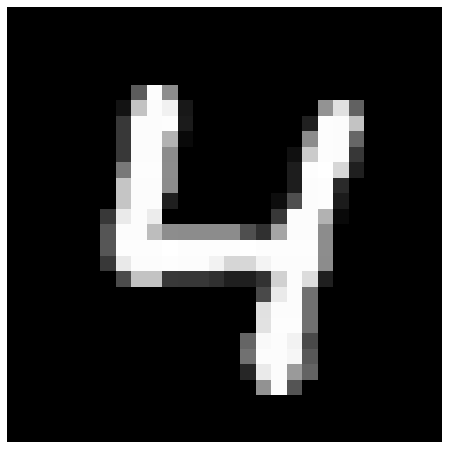

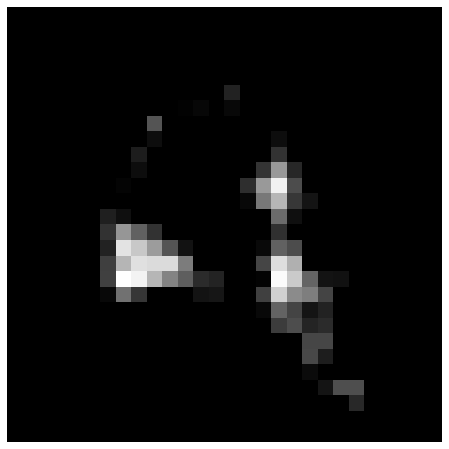

In [11]:
autoencoder = StackedDenoisingAutoEncoder(
    get_linears('dec', 784, 10),
    activation=ReLU(),
    final_activation=ReLU(),
    dropout=0.0,
    is_tied=True,
)
autoencoder.to(device)
autoencoder.load_state_dict(torch.load(PATH_TO_MODELS/filename/'pretrain_ae'))
r_data = []
data = []
criterion = MSELoss()
cl_recon = 0.0
for i, batch in enumerate(validation_loader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
        batch = batch.to(device, non_blocking=True)
        data.append(batch.cpu())
        r_batch = autoencoder(batch)
        r_data.append(r_batch.cpu())
        loss = criterion(r_batch, batch)
        cl_recon += loss.cpu().numpy()
    
cl_recon = (cl_recon / (i+1))
r_data = torch.cat(r_data).numpy()
data = torch.cat(data).numpy()
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(r_data[56].reshape((28,28)), interpolation='none', cmap='gray')
plt.axis('off')
plt.savefig('recon_img.png')
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(data[56].reshape((28,28)), interpolation='none', cmap='gray')
plt.axis('off')
plt.savefig('orig_img.png')
model = DEC(cluster_number=10,
            hidden_dimension=10,
            encoder=autoencoder.encoder,
            alpha=9)
model = model.to(device)
model.load_state_dict(torch.load(PATH_TO_MODELS/filename/'dec_model'))
r_data = []
for i, batch in enumerate(validation_loader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
        batch = batch.to(device, non_blocking=True)
        r_batch = autoencoder(batch)
        r_data.append(r_batch.cpu())
r_data = torch.cat(r_data).numpy()
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(r_data[56].reshape((28,28)), interpolation='none', cmap='gray')
plt.axis('off')
plt.savefig('cl_img.png')


In [13]:
cl_recon

0.013925473601557315

Evaluate model.

In [9]:
cl_recon = 0.0
criterion = MSELoss()
data = []
r_data = []
features = []
prob_labels = []
r_prob_labels = []
actual = []
model.eval()
autoencoder.eval()
for i, batch in enumerate(validation_loader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
            actual.append(value.cpu())
            data.append(batch.cpu())
        batch = batch.to(device, non_blocking=True)
        r_batch = autoencoder(batch)
        f_batch = autoencoder.encoder(batch)
        features.append(f_batch.cpu())
        r_data.append(r_batch.cpu())
        loss = criterion(r_batch, batch)
        cl_recon += loss.cpu().numpy()
        prob_labels.append(model(batch).cpu())
        r_prob_labels.append(model(r_batch).cpu())

cl_recon = (cl_recon / (i+1))
predicted = torch.cat(prob_labels).max(1)[1]
r_predicted = torch.cat(r_prob_labels).max(1)[1]
actual = torch.cat(actual).long()
data = torch.cat(data).numpy()
r_data = torch.cat(r_data).numpy()
features = torch.cat(features).numpy()

In [10]:
cl_recon

0.13567651510238649

Reassignemnt of label to respect actual labels.

In [6]:
reassignment, accuracy = cluster_accuracy(actual.numpy(), predicted.numpy())
predicted_reassigned = [reassignment[item] for item in predicted.numpy()]

Plotting confusion matrices for accuracy and cycle accuracy.

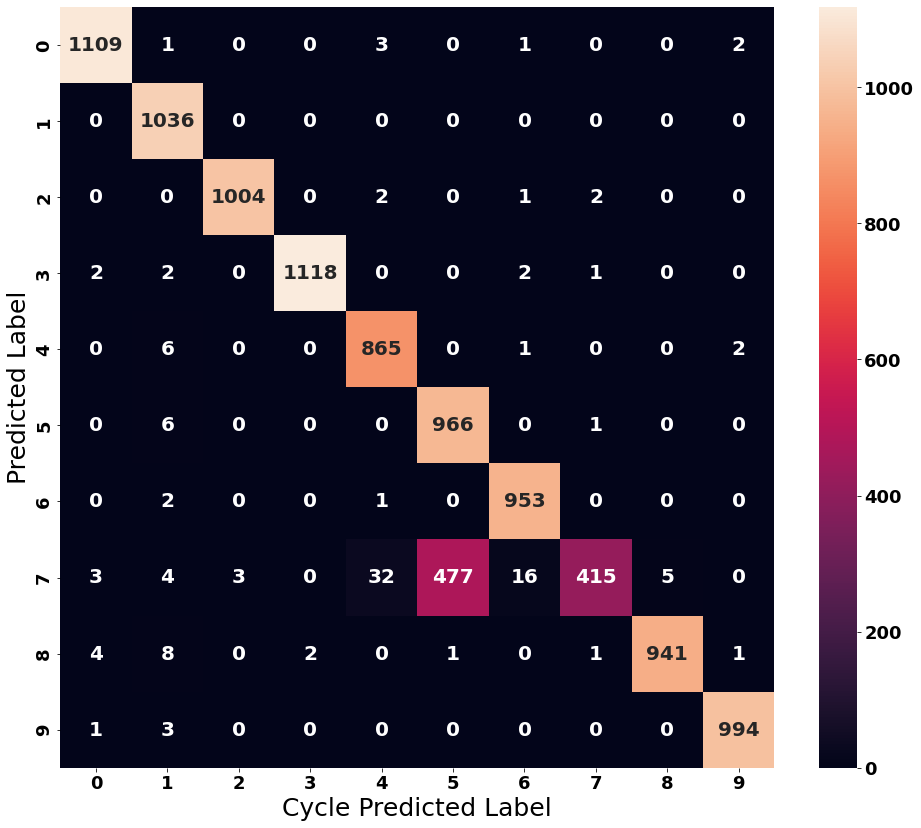

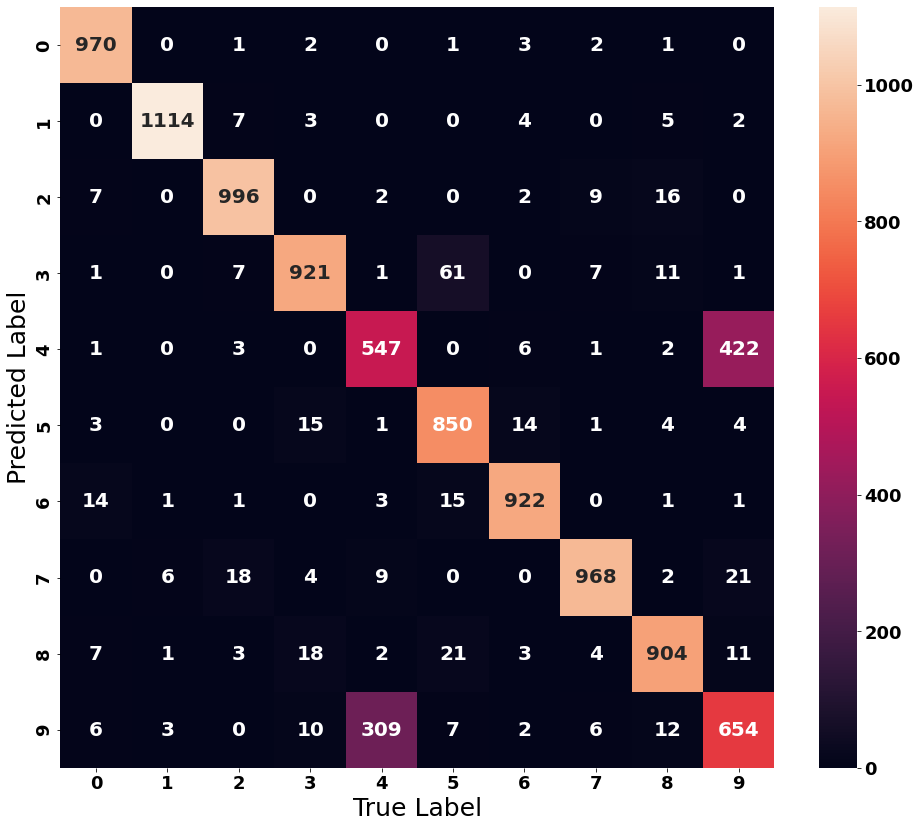

In [8]:
confusion_matrix = sklearn.metrics.confusion_matrix(predicted, r_predicted)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
# plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('Cycle Predicted Label', fontsize=25)
plt.savefig('conf_matrix_cycle_accuracy_best_{}.png'. \
    format(
        'bmnist' if binary else 'mnist'
    ))

confusion_matrix = sklearn.metrics.confusion_matrix(actual, predicted_reassigned)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
# plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('True Label', fontsize=25)
plt.savefig('conf_matrix_accuracy_best_{}.png'. \
    format(
        'bmnist' if binary else 'mnist'
    ))

Plotting reduced representation of feature space after completing the clustering step.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


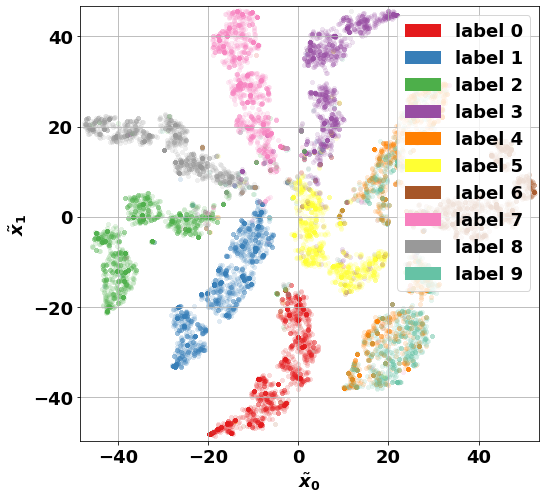

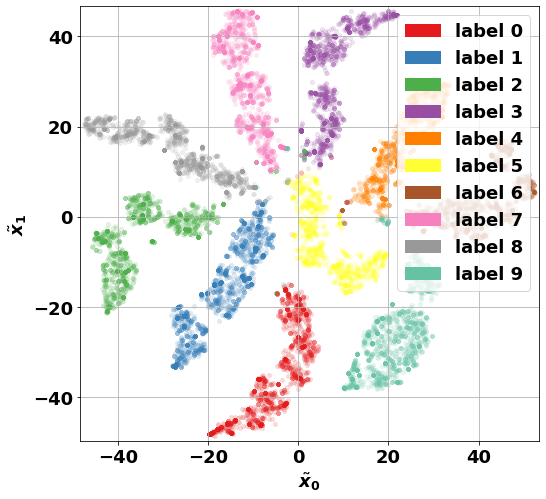

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


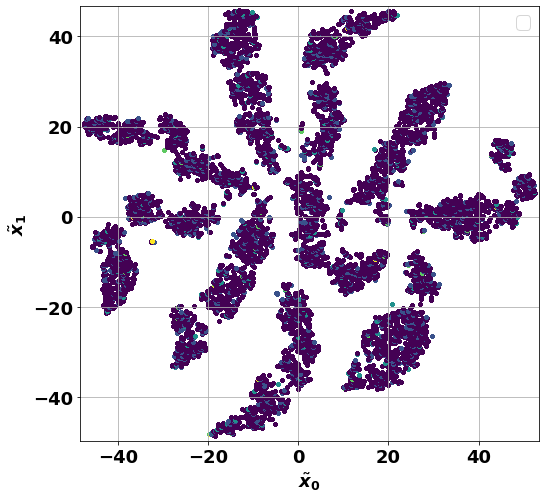

In [9]:
delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


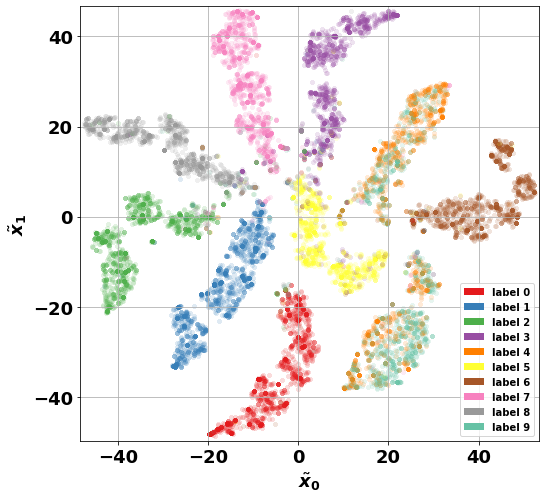

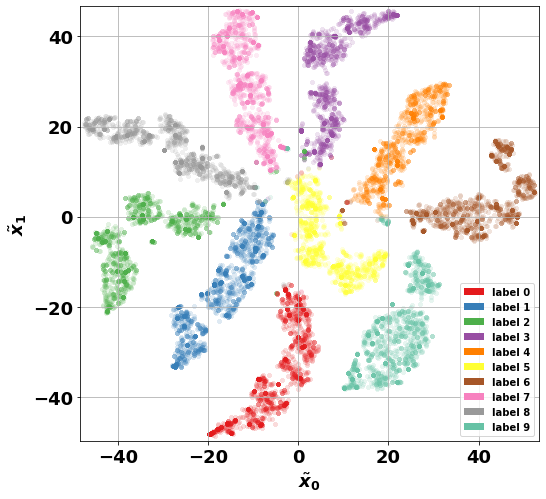

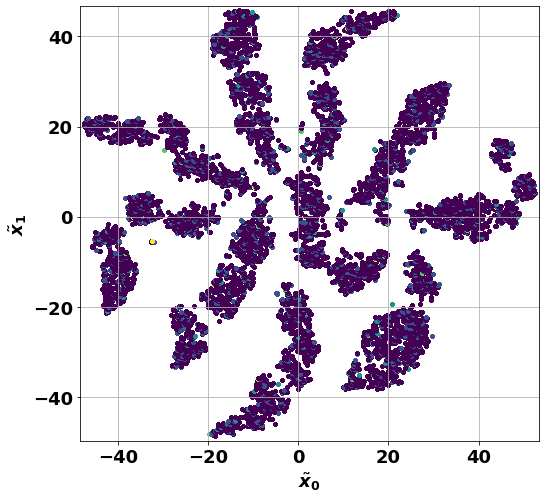

In [14]:


points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])
points['y'] = ['label {}'.format(l) for l in actual.numpy()]
points['y'] = points['y'].astype("category")

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = 'tab10'
agg = ds.count_cat('y')

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')
plt.legend(handles=artist.get_legend_elements(), prop={'size': 10}, loc='lower right')

plt.savefig('cluster_tsne_space_{}_cl_best_actual.png'. \
    format(
        'bmnist' if binary else 'mnist'
           ))
plt.show()

points['y'] = ['label {}'.format(l) for l in predicted_reassigned]
points['y'] = points['y'].astype("category")

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = 'tab10'
agg = ds.count_cat('y')

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')
plt.legend(handles=artist.get_legend_elements(), prop={'size': 10}, loc='lower right')

plt.savefig('cluster_tsne_space_{}_cl_best_predicted.png'. \
    format(
        'bmnist' if binary else 'mnist'
           ))
plt.show()


fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None
agg = ds.count()

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('cluster_tsne_space_{}_cl_best_nolbl.png'. \
    format(
        'bmnist' if binary else 'mnist'
           ))
plt.show()

Plotting reduced representation of feature space after completing the training of TSDAE.

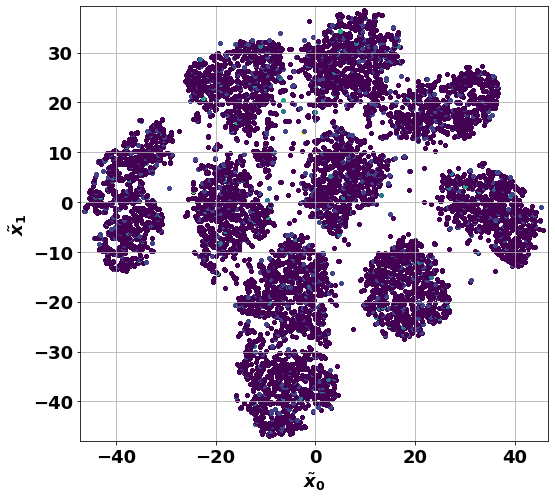

In [15]:
autoencoder.load_state_dict(torch.load(PATH_TO_MODELS/filename/'pretrain_ae'))

features = []
actual = []
autoencoder.eval()
for i, batch in enumerate(validation_loader):
    with torch.no_grad():
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch
            actual.append(value.cpu())
        batch = batch.to(device, non_blocking=True)
        f_batch = autoencoder.encoder(batch)
        features.append(f_batch.cpu())
actual = torch.cat(actual).long()
features = torch.cat(features).numpy()

delta = 1.0

tsne = TSNE(
    n_components=2,
    n_jobs=-1,
    random_state=51550
).fit_transform(features)


points = pd.DataFrame(tsne[:len(features)], columns=['x0', 'x1'])

fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)

agg = ds.count()
cmap = None

artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
        shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
plt.grid()
plt.xlabel(r'$\tilde{x}_0$')
plt.ylabel(r'$\tilde{x}_1$')

plt.savefig('ae_tsne_space_{}_cl_best.png'. \
    format(
        'bmnist' if binary else 'mnist'
           ))
plt.show()